In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
%matplotlib inline

In [3]:
#read data 
df = pd.read_csv('combined.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49636 entries, 0 to 49635
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            49636 non-null  int64  
 1   ACCIDENTDATE          49636 non-null  object 
 2   AOTACTUALMILEPOINT    49636 non-null  object 
 3   AOTROUTE              49299 non-null  object 
 4   Animal                49636 non-null  object 
 5   CITYORTOWN            49505 non-null  object 
 6   DIROFCOLLI            37121 non-null  object 
 7   DayNight              49636 non-null  object 
 8   HOWMAPPED             49110 non-null  object 
 9   INTERSECTIONWITH      40181 non-null  object 
 10  Impairment            49636 non-null  object 
 11  InjuryType            49636 non-null  object 
 12  Involving             49636 non-null  object 
 13  LAT_DD                49110 non-null  float64
 14  LOCALID               39326 non-null  float64
 15  LOC_ERROR          

In [4]:
# Preprocess data
AOTRoute = pd.Series(np.where(((df['AOTROUTE'] != 'US-7')&(df['AOTROUTE'] != 'I-89')&
                            (df['AOTROUTE'] != 'I-91')&(df['AOTROUTE'] != 'US-2')&
                            (df['AOTROUTE'] != 'US-5')&(df['AOTROUTE'] != 'VT-15')&
                            (df['AOTROUTE'] != 'VT-100')&(df['AOTROUTE'] != 'VT-9')&
                            (df['AOTROUTE'] != 'VT-2A')&(df['AOTROUTE'] != 'US-4')),'Other',df.AOTROUTE))
AOTRoute = pd.get_dummies(AOTRoute)

# get dummies for animal --> get "none" column for yes/no
animal = pd.get_dummies(df['Animal'])['None/Other']
#recode 0 to 1 and 1 to 0; this way a 1 is yes
animal = pd.Series(np.where(np.array(animal)==0,1,0))

city_town = pd.Series(np.where(((df['CITYORTOWN'] != 'Burlington')&(df['CITYORTOWN'] != 'Brattleboro')&
                            (df['CITYORTOWN'] != 'South Burlington')&(df['CITYORTOWN'] != 'Essex')&
                            (df['CITYORTOWN'] != 'Bennington')&(df['CITYORTOWN'] != 'Williston')&
                            (df['CITYORTOWN'] != 'Colchester')&(df['CITYORTOWN'] != 'Springfield')&
                            (df['CITYORTOWN'] != 'Hartford')&(df['CITYORTOWN'] != 'Milton')),'Other',df.CITYORTOWN))
city_town = pd.get_dummies(city_town)

# DayNight --> save "night" case only as yes/no
night=pd.get_dummies(df['DayNight'])['Night']

# Impairment --> get "none" column for yes/no
impairment=pd.get_dummies(df['Impairment'])['None']
#recode 0 to 1 and 1 to 0; this way a 1 is yes
impairment = pd.Series(np.where(np.array(impairment)==0,1,0))

# get dummies for Involving
involving = pd.get_dummies(df['Involving'])
# remove "none" column which is the null case
involving = involving.drop(columns = ['None'])

# Get dummies for road condition
roadcondition = pd.get_dummies(df['RoadCondition'])
# drop "none" column which is the null case, unreported situations, and the surface condition; will add in later
roadcondition = roadcondition.drop(columns=['None', 'Other - Explain in Narrative', 'Not reported', 'Unknown',
                                            'Road Surface Condition(wet, icy, snow, slush, etc)'])

# get dummies for surface condition
surfacecondition = pd.get_dummies(df['SurfaceCondition'])
# drop "dry" column which is the null case along with unreported situations
surfacecondition = surfacecondition.drop(columns=['Dry', 'Not Reported', 'Other - Explain in Narrative', 'Unknown'])

# get dummies for weather
weather = pd.get_dummies(df['Weather'])
# drop "clear" column which is the null case along with unreported situations
weather = weather.drop(columns=['Clear', 'Unknown'])

# get accident dates
datetime = df['ACCIDENTDATE']
months = '' # new string
# use loop to extract month from date string
for i in range(len(datetime)):
    match = re.search(r'\d{4}-\d{2}-\d{2}', datetime[i]).group()
    months += match[5:7] + ','
# remove last extraneous comma from loop
months = months[:-1]
# split comma separated string
months = months.split(",")
# convert to DataFrame
months = pd.Series(months)

# determine season
seasons = ""
for i in range(len(months)):
    if months[i]=='12':
        seasons += 'Winter' + ','
    if months[i]=='01':
        seasons += 'Winter' + ','
    if months[i]=='02':
        seasons += 'Winter' + ','
    if months[i]=='03':
        seasons += 'Spring' + ','
    if months[i]=='04':
        seasons += 'Spring' + ','
    if months[i]=='05':
        seasons += 'Spring' + ','
    if months[i]=='06':
        seasons += 'Summer' + ','
    if months[i]=='07':
        seasons += 'Summer' + ','
    if months[i]=='08':
        seasons += 'Summer' + ','
    if months[i]=='09':
        seasons += 'Fall' + ','
    if months[i]=='10':
        seasons += 'Fall' + ','
    if months[i]=='11':
        seasons += 'Fall' + ','
# remove last extraneous comma from loop
seasons = seasons[:-1]
# split comma separated string
seasons = seasons.split(",")
# convert to DataFrame
seasons = pd.Series(seasons)
seasons = pd.get_dummies(seasons)

injury = df['InjuryType'].copy()

for i in range(len(injury)):
    if injury.loc[i] == 'Property Damage Only':
        injury.loc[i] = 0
    else:
        injury.loc[i] = 1

# Build data frame for RF
rf_df = pd.concat([animal, night, impairment], axis=1)
rf_df.columns=['Animal', 'Night', 'Impairment']
rf_df = pd.concat([rf_df, AOTRoute, city_town, involving, roadcondition, surfacecondition, weather, seasons,injury],
                   axis=1, sort=False)

rf_df.rename(columns={'InjuryType':'injury'},  inplace=True)
rf_df.head()

,Animal,Night,Impairment,I-89,I-91,Other,US-2,US-4,US-5,US-7,...,Wet,Cloudy,Freezing Precipitation,Rain,Wind,Fall,Spring,Summer,Winter,injury
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
2,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [418]:
rf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49636 entries, 0 to 49635
Data columns (total 52 columns):
 #   Column                                                    Non-Null Count  Dtype 
---  ------                                                    --------------  ----- 
 0   Animal                                                    49636 non-null  int32 
 1   Night                                                     49636 non-null  uint8 
 2   Impairment                                                49636 non-null  int32 
 3   I-89                                                      49636 non-null  uint8 
 4   I-91                                                      49636 non-null  uint8 
 5   Other                                                     49636 non-null  uint8 
 6   US-2                                                      49636 non-null  uint8 
 7   US-4                                                      49636 non-null  uint8 
 8   US-5                      

In [435]:
#assign the dependent variable as injury, and the independent variable as the rest of the data
dv=rf_df['injury'].astype(int)
iv = rf_df.copy()
iv = iv.drop(['injury'], axis=1)


In [436]:
from sklearn.model_selection import train_test_split
#split the independent and dependent variables into train and test sets
dv_train, dv_test, iv_train, iv_test = train_test_split(dv, iv, test_size = .2, random_state=123)

In [451]:
import statsmodels.api as sm
#create a logistic regression model with summary statistics 
mod = sm.Logit(dv_train,iv_train)
# Fit model
fit = mod.fit()
# Summarize model
fit.summary()

         Current function value: 0.453351
         Iterations: 35


c:\users\kyle johnson\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 injury   No. Observations:                39708
Model:                          Logit   Df Residuals:                    39659
Method:                           MLE   Df Model:                           48
Date:                Mon, 04 May 2020   Pseudo R-squ.:                  0.1013
Time:                        14:48:37   Log-Likelihood:                -18002.
converged:                      False   LL-Null:                       -20032.
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================================================
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Animal                                                      -1.1227      0.103    -10.943      0.000      -1.324      -0.922
Night                                                        0.0538      0.031      1.715      0.086      -0.008       0.115
Impairment                                                   0.9566      0.050     19.278      0.000       0.859       1.054
I-89                                                        -0.2324        nan        nan        nan         nan         nan
I-91                                                        -0.3397        nan        nan        nan         nan         nan
Other                                                       -0.5991        nan        nan        nan         nan         nan
US-2                                                        -0.1844        nan        nan        nan         nan         nan
US-4                                                        -0.4574        nan        nan        nan         nan         nan
US-5                                                        -0.5138        nan        nan        nan         nan         nan
US-7                                                        -0.4701        nan        nan        nan         nan         nan
VT-100                                                      -0.5576        nan        nan        nan         nan         nan
VT-15                                                       -0.2984        nan        nan        nan         nan         nan
VT-2A                                                       -0.5409        nan        nan        nan         nan         nan
VT-9                                                        -0.1413        nan        nan        nan         nan         nan
Bennington                                                  -0.4655        nan        nan        nan         nan         nan
Brattleboro                                                 -0.4986        nan        nan        nan         nan         nan
Burlington                                                  -0.8859        nan        nan        nan         nan         nan
Colchester                                                   0.3396        nan        nan        nan         nan         nan
Essex                                                       -1.0776        nan        nan        nan         nan         nan
Hartford                                                     0.0219        nan        nan        nan         nan         nan
Milton                                                      -0.1550        nan        nan        nan         nan         nan
Other                                                        0.3471        nan        nan        nan         nan         nan
South Burlington                                            -0.8428        nan        nan        nan         nan    

In [455]:
from sklearn.linear_model import LogisticRegression
#create a logisitic regression model
lr = LogisticRegression(max_iter=1000)
#fit model
fit = lr.fit(iv_train,dv_train)

In [431]:
#create prediction set
dv_pred = lr.predict(iv_test)
#create a confusion matrix for the test data vs the predicted data
confusion_matrix(dv_test, dv_pred)

array([[7823,  101],
       [1730,  274]], dtype=int64)

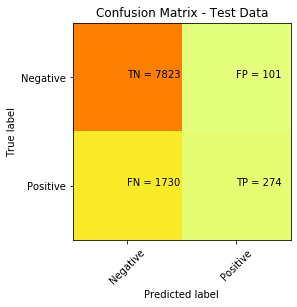

In [440]:
from sklearn import metrics


def print_cm(cm):
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('Confusion Matrix - Test Data')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']] 
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()
    
print_cm(metrics.confusion_matrix(dv_test, dv_pred))

In [441]:
metrics.accuracy_score(dv_test, dv_pred)

0.8155721192586624

In [442]:
metrics.roc_auc_score(dv_test, dv_pred)

0.5619902295358803

In [272]:
metrics.cohen_kappa_score(dv_test, dv_pred)

0.1780428321728913

In [274]:
print(metrics.classification_report(dv_test, dv_pred))

              precision    recall  f1-score   support

           0       0.82      0.99      0.90      7924
           1       0.73      0.14      0.23      2004

    accuracy                           0.82      9928
   macro avg       0.77      0.56      0.56      9928
weighted avg       0.80      0.82      0.76      9928



In [299]:
from sklearn import ensemble

original_params = {'n_estimators': 1000, 'max_leaf_nodes': 4, 'max_depth': None, 'random_state': 2,
                   'min_samples_split': 5}
clf = ensemble.GradientBoostingClassifier(**original_params)
clf.fit(iv_train, dv_train)
# compute test set deviance
test_deviance = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_decision_function(iv_test)):
        # clf.loss_ assumes that y_test[i] in {0, 1}
        test_deviance[i] = clf.loss_(dv_test, dv_pred)

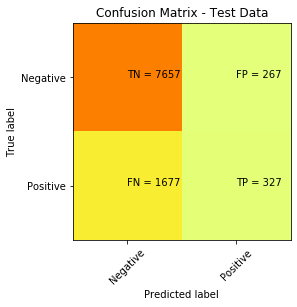

In [410]:
import matplotlib.pyplot as plt
#create x and y values from the iv and dv training sets
x=iv_train
y=dv_train
#set optimal parameters
params = {
    'n_estimators': 200,
    'max_depth': 23,
    'learning_rate': 1,
    'criterion': 'friedman_mse'
}
#add parameters to GBC
gbc = ensemble.GradientBoostingClassifier(**params)
#fit model
gbc.fit(x, y)
#create predicted set
dv_pred = gbc.predict(iv_test)
gbc_score = gradient_boosting_classifier.score(iv_test,dv_test)
#show confusion matrix for predicted data vs test data.
print_cm(metrics.confusion_matrix(dv_test, dv_pred))

In [411]:
#find auc score for GBC
metrics.roc_auc_score(dv_test, dv_pred)

0.5647392746057607

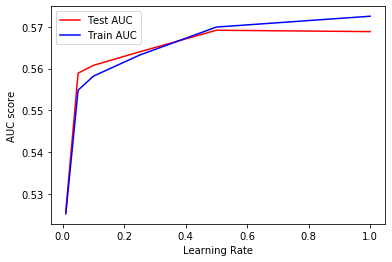

In [403]:
import matplotlib.pyplot as plt
#the next 3 segments are test models for different parameters. 
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
train_results = []
test_results = []
for eta in learning_rates:
    params = {
    'n_estimators': 100,
    'max_depth': 3,
    'learning_rate': eta,
    'criterion': 'friedman_mse'
    }

    gbc = ensemble.GradientBoostingClassifier(**params)

    gbc.fit(x, y)
    train_pred = gbc.predict(iv_train)
    test_pred = gbc.predict(iv_test)
    train_results.append(metrics.roc_auc_score(dv_train, train_pred))
    test_results.append(metrics.roc_auc_score(dv_test, test_pred))
    
line1 = plt.plot(learning_rates, test_results, 'r', label='Test AUC')
line2 = plt.plot(learning_rates, train_results, 'b', label='Train AUC')
plt.legend()
plt.ylabel('AUC score')
plt.xlabel('Learning Rate')
plt.show()
    

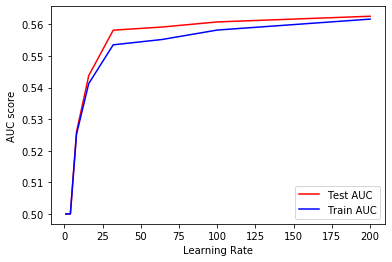

In [405]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for eta in n_estimators:
    params = {
    'n_estimators': eta,
    'max_depth': 3,
    'learning_rate': .1,
    'criterion': 'friedman_mse'
    }

    gbc = ensemble.GradientBoostingClassifier(**params)

    gbc.fit(x, y)
    train_pred = gbc.predict(iv_train)
    test_pred = gbc.predict(iv_test)
    train_results.append(metrics.roc_auc_score(dv_train, train_pred))
    test_results.append(metrics.roc_auc_score(dv_test, test_pred))
    
line1 = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
line2 = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
plt.legend()
plt.ylabel('AUC score')
plt.xlabel('Number of Estimators')
plt.show()

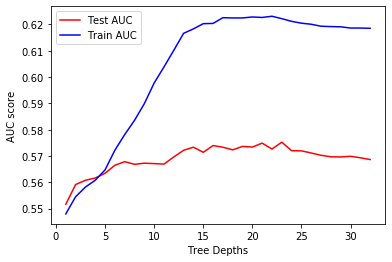

In [409]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for eta in max_depths:
    params = {
    'n_estimators': 100,
    'max_depth': eta,
    'learning_rate': .1,
    'criterion': 'friedman_mse'
    }

    gbc = ensemble.GradientBoostingClassifier(**params)

    gbc.fit(x, y)
    train_pred = gbc.predict(iv_train)
    test_pred = gbc.predict(iv_test)
    train_results.append(metrics.roc_auc_score(dv_train, train_pred))
    test_results.append(metrics.roc_auc_score(dv_test, test_pred))
    
line1 = plt.plot(max_depths, test_results, 'r', label='Test AUC')
line2 = plt.plot(max_depths, train_results, 'b', label='Train AUC')
plt.legend()
plt.ylabel('AUC score')
plt.xlabel('Tree Depths')
plt.show()